# Permutation Importance

The process is as follows:

    - Get a trained model
    - Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
    - Return the data to the original order (undoing the shuffle from step 2.) Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.

We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

 Do you know what the difference is with an other technique whereby you systematically removes one feature and see how the performance of the model changes? The removed feature with the largest performance drop is (most likely) the most important feature.
 
     - They behave similarly if you don't have high correlation between any features, but behave very differently if you have highly correlated features. You can imagine that if you had two features that were nearly identical, shuffling one of them would still hurt accuracy… while removing one before training wouldn't matter.

    - It's a little too much to go into detail when you'd prefer one vs the other in a comment… but broadly speaking, permutation importance is closer to "how much does this model rely on a feature" instead of "how much does the feature help our ability to make predictions."

    - Also, permutation importance is MUCH faster to calculate, because the model doesn't need to be refit an extra time for each column, which is computationally prohibitive in many cases. 

Does permutation importance tell you what interactions are important: **No**

Does permutation importance account for the possibility that a variable could be important even if it's only through the type of interaction you described: **Yes**

For the latter, imagine that you have a plant that grows only if it gets both sun and water. If we randomly shuffle the water column, our predictions will be quite bad. Because some plants grew tall, and after shuffling it will appear they only got water or only got sun.

This technique can be a little slow if you have a large number of columns and a large validation data set, but it's still (usually faster) than the model-fitting.

As for deep learning, it depends. If you are using a deep learning model on tabular data, it can work well. If you have an image, text, sound, etc… this isn't a good fit. There are other techniques (SHAP values, which we cover in Days 3-4 can work, LIME is similar to SHAP and also works, and there are some nice visualization techniques for Convolutional Models). 

 https://www.kaggle.com/dansbecker/permutation-importance

In [7]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox import pdp, get_dataset, info_plots

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_file = '../data/train.csv'
df_train = pd.read_csv(train_file)
df_train.drop(['ID_code'], axis=1, inplace=True)
target = df_train.pop('target')

In [ ]:
feature_names = [i for i in df_train.columns if df_train[i].dtype in [np.int64, np.float64]]
X = df_train[feature_names]

train_X, val_X, train_y, val_y = train_test_split(X, target, random_state=1)

my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [7]:
perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0002 ± 0.0002,var_110
0.0001 ± 0.0001,var_157
0.0001 ± 0.0001,var_162
0.0001 ± 0.0001,var_42
0.0001 ± 0.0002,var_170
0.0001 ± 0.0002,var_174
0.0001 ± 0.0001,var_188
0.0001 ± 0.0001,var_147
0.0001 ± 0.0001,var_197
0.0001 ± 0.0001,var_47


Not very informative in this scenario, just tells us that var 110 is important,  which is **not clearly seen** in lgbm importance plot

# Partial Plots


This is useful to answer questions like:

    - Controlling for all other house features, what impact do longitude and latitude have on home prices? To restate this, how would similarly sized houses be priced in different areas?

    - Are predicted health differences between two groups due to differences in their diets, or due to some other factor?

If you are familiar with linear or logistic regression models, partial dependence plots can be interepreted similarly to the coefficients in those models. Though, partial dependence plots on sophisticated models can capture more complex patterns than coefficients from simple models.

How it Works:
    
    - Like permutation importance, partial dependence plots are calculated after a model has been fit. The model is fit on real data that has not been artificially manipulated in any way.

    - In our soccer example, teams may differ in many ways. How many passes they made, shots they took, goals they scored, etc. At first glance, it seems difficult to disentangle the effect of these features.

    - To see how partial plots separate out the effect of each feature, we start by considering a single row of data. For example, that row of data might represent a team that had the ball 50% of the time, made 100 passes, took 10 shots and scored 1 goal.

We will use the fitted model to predict our outcome. But we repeatedly alter the value for one variable to make a series of predictions. We could predict the outcome with varying the feature values and trace it out (on the vertical axis) as we move from small values of the variable to large values (on the horizontal axis).

In this description, we used only a single row of data. Interactions between features may cause the plot for a single row to be atypical. So, we repeat that mental experiment with multiple rows from the original dataset, and we plot the average predicted outcome on the vertical axis.

In [4]:
train_X, val_X, train_y, val_y = train_test_split(df_train, target, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

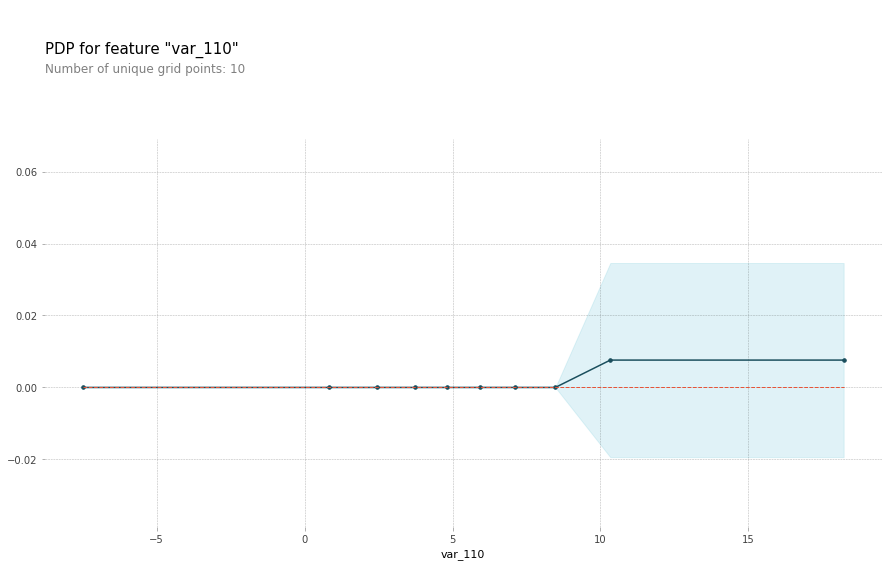

In [8]:
feat_var = 'var_110'
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=list(df_train.columns), feature=feat_var)

# plot it
pdp.pdp_plot(pdp_goals, feat_var)
plt.show()